In [12]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle")
import statsmodels.api as sm

# Set path
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
# from common.functions import portstats_bm

# 1 Introduction

Here you will assess trade flow as means of generating profit opportunities in 3 cryptotoken markets. We stress the word “opportunity” because at high data rates like these, and given the markets’ price-time priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably into the fray.

# 2 Data

We have preprocessed level 2 exchange messages from the Coinbase WebSocket API for you into a more digestible format.

#### 2.1 Treatment

Load the 2021 data for all 3 pairs from the class website. For each one, split it into test and training sets, with your training set containing the first 20% of the data and the test set containing the remainder.

#### 2.2 Format

The data has the following structure

In [2]:
DATADIR = "../data/2021/For_Homework/"
READ_BOOK = False

books, trades = {}, {}

for filename in os.listdir(DATADIR):
    pair = re.findall(r'[A-Z]{3}-[A-Z]{3}', filename)[0]
    
    if filename[:6]=="trades":
        trades[pair] = pd.read_csv(DATADIR + filename, compression="gzip", sep='\t')
    elif filename[:4]=="book" and READ_BOOK:
        books[pair] = pd.read_csv(DATADIR + filename, compression="gzip", sep='\t')
    else:
        print(f"Not reading {filename}")
        
print(f"Trades {trades.keys()}")

Not reading book_narrow_ETH-USD_2021.delim.gz
Not reading book_narrow_ETH-BTC_2021.delim.gz
Not reading book_narrow_BTC-USD_2021.delim.gz
Trades dict_keys(['ETH-BTC', 'BTC-USD', 'ETH-USD'])


## Visualize the data

To understand its characteristics...

In [3]:
trades["ETH-BTC"].head(3)

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618090137140737000,1618090137157544000,35690,1000000,-1
1,1618090137851379000,1618090137864544000,35700,29801980,2
2,1618090143777062000,1618090143793909000,35700,4641070,1


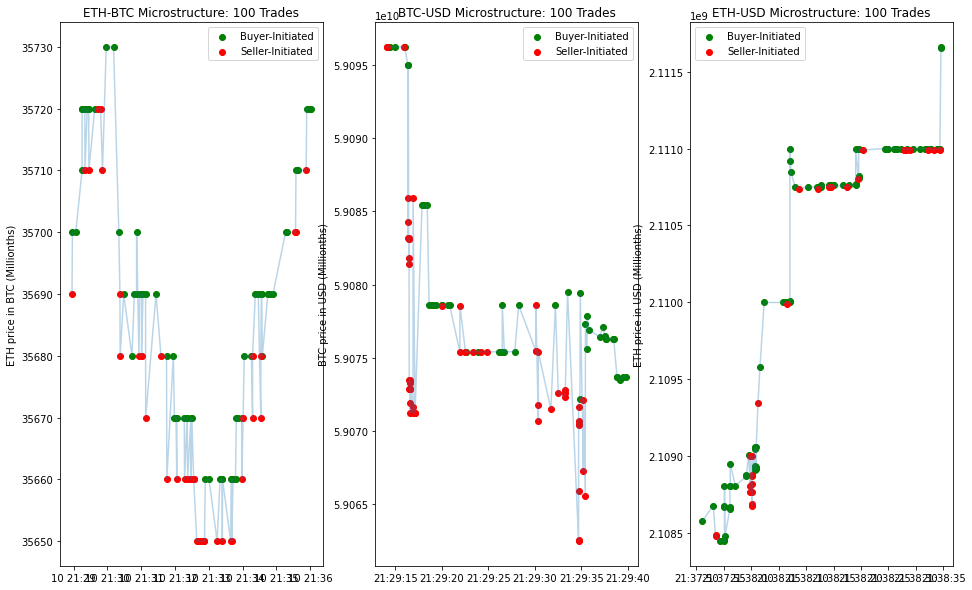

In [4]:
def visualize_microstructure(trades, pair, interval, ax):
    start, end = interval[0], interval[1]
    plot_df = trades[pair].iloc[start:end,:]
    X = pd.to_datetime(plot_df["timestamp_utc_nanoseconds"])
    Y = plot_df["PriceMillionths"]

    ax.scatter(X[plot_df["Side"]>0], Y[plot_df["Side"]>0], c='g', label="Buyer-Initiated")
    ax.scatter(X[plot_df["Side"]<0], Y[plot_df["Side"]<0], c='r', label="Seller-Initiated")
    ax.plot(X, Y, alpha=0.3)
    ax.legend()
    ax.set_title(f"{pair} Microstructure: {end-start} Trades")
    ax.set_ylabel(f"{pair.replace('-', ' price in ')} (Millionths)")


fig, axs = plt.subplots(1,3)

visualize_microstructure(trades, "ETH-BTC", [0, 100], axs[0])
visualize_microstructure(trades, "BTC-USD", [100, 200], axs[1])
visualize_microstructure(trades, "ETH-USD", [1000, 1100], axs[2])
plt.show()

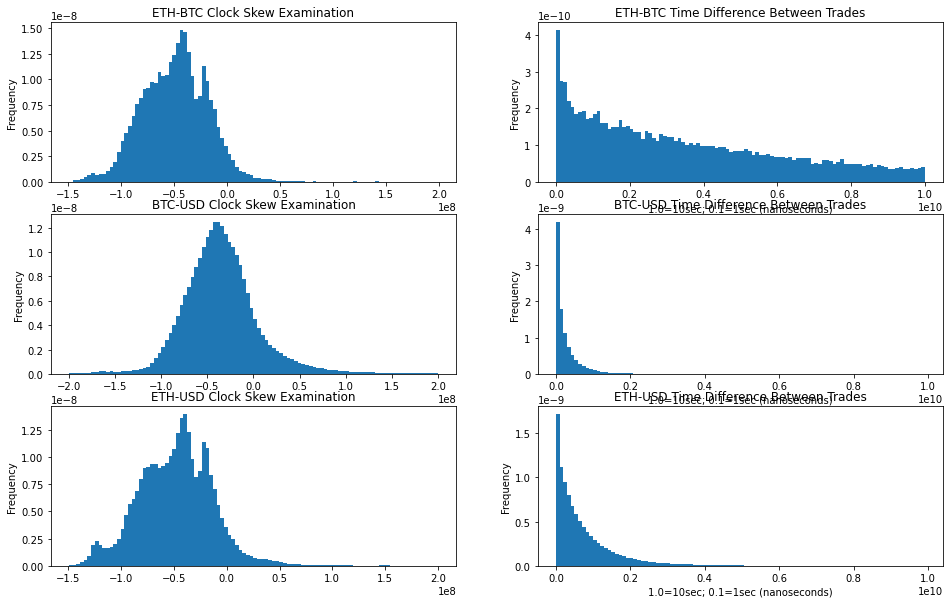

In [5]:
def visualize_delays(trades, pair, axs):
    trd_raw = trades[pair]

    latency = (trd_raw["received_utc_nanoseconds"] - trd_raw["timestamp_utc_nanoseconds"])
    latency[np.abs(latency)<2e8].plot.hist(bins=100, ax=axs[0], density=True)
    axs[0].set_title(f"{pair} Clock Skew Examination")

    dt = trd_raw["timestamp_utc_nanoseconds"].diff()

    dt[(0<dt) & (dt<1e10)].plot.hist(bins=100, density=True, ax=axs[1])
    axs[1].set_title(f"{pair} Time Difference Between Trades")
    axs[1].set_xlabel("1.0=10sec; 0.1=1sec (nanoseconds)")


fig, axs = plt.subplots(3,2)

visualize_delays(trades, "ETH-BTC", axs[0])
visualize_delays(trades, "BTC-USD", axs[1])
visualize_delays(trades, "ETH-USD", axs[2])
plt.show()

## Analysis: Microstructure, Clock Skew, and Trade Time Difference



# 3 Exercise

Write code to find τ-interval trade flow F(τ) just prior2 to each trade data point3 i. Compute T-second i
forward returns4 r(T). Regress them against each other in your training set, to find a coefficient β of i
regression.

For each data point in your test set you already have F(τ), so your return prediction is rˆ := β · F(τ).
Define a threshold j for rˆ and assume you might attempt to trade whenever j < |rˆ | .

$$\begin{aligned}
    \text{Flow }&:= f_t(v,s) \\
    \text{Volume }&:= v \\
    \text{Size }&:= s \\
    \int_{t_i-\tau}^{t_i} f_t(v,s)dt &= \int_{0}^{t_i} f_t(v,s) dt - \int_{0}^{t_i-\tau} f_t(v,s) dt
\end{aligned}$$

In [7]:
def create_backward(df: pd.DataFrame, tau: int):
    df = df.copy(deep=True)
    df["dflow"] = (df["SizeBillionths"] * (df["Side"] > 0) 
                   - df["SizeBillionths"] * (df["Side"] < 0))
    df["vap"] = (df["PriceMillionths"]/1e6) * (df["SizeBillionths"]/1e9)
    df.rename(columns={"timestamp_utc_nanoseconds": "ts"}, inplace=True)
    
    # Build backward looking "flow" and "vwap"
    flow = df.set_index("ts")[["dflow", "SizeBillionths", "vap"]].cumsum()
    shift = flow.copy(deep=True)
    
    shift.index += tau
    flow.rename(columns= {"dflow": "flow",  "SizeBillionths": "vol"}, inplace=True)
    shift.rename(columns={"dflow": "sflow", "SizeBillionths": "svol", "vap": "svap"}, inplace=True)
    
    unholy = pd.concat([flow, shift], axis=0)
    unholy.sort_index(inplace=True)
    unholy[["sflow", "svol", "svap"]] = unholy[["sflow", "svol", "svap"]].fillna(method="ffill")
    
    back = unholy[["flow", "vol", "vap"]] - unholy[["sflow", "svol", "svap"]].fillna(0).values
    back.reset_index(inplace=True)
    back = back.dropna()
    back.index = df.index
    back["vwap"] = back["vap"] / back["vol"] * 1e9
    
    return back

def create_forward(df: pd.DataFrame, T: int):
    df = df.copy(deep=True)
    df["dflow"] = (df["SizeBillionths"] * (df["Side"] > 0) 
                   - df["SizeBillionths"] * (df["Side"] < 0))
    df["vap"] = (df["PriceMillionths"]/1e6) * (df["SizeBillionths"]/1e9)
    df.rename(columns={"timestamp_utc_nanoseconds": "ts"}, inplace=True)
    
    # Build forward looking "price" and "vwap"
    price = df.set_index("ts")[["PriceMillionths", "SizeBillionths", "vap"]]
    price[["SizeBillionths", "vap"]] = price[["SizeBillionths", "vap"]].cumsum()
    shift = price.copy(deep=True)
    
    shift.index -= T
    price.rename(columns={"PriceMillionths": "price", "SizeBillionths": "vol"}, inplace=True)
    shift.rename(columns={"PriceMillionths": "sprice", "SizeBillionths": "svol", "vap": "svap"}, inplace=True)
    
    unholy = pd.concat([price, shift], axis=0)
    unholy.sort_index(inplace=True)
    unholy[["sprice", "svol", "svap"]] = unholy[["sprice", "svol", "svap"]].fillna(method="ffill")
    
    fwd = unholy[["sprice"]].copy(deep=True)
    fwd.reset_index(inplace=True)
    fwd[["vol", "vap"]] = unholy[["svol", "svap"]].subtract(unholy[["vol", "vap"]].fillna(0).values, axis=0).values
    fwd = fwd[~unholy["price"].isna().values]
    fwd.index = df.index
    fwd["vwap"] = fwd["vap"] / fwd["vol"] * 1e9
    
    return fwd

def merge_together(df, back, fwd):
    new = df.merge(back, left_index=True, right_index=True)
    new.rename(columns={"received_utc_nanoseconds": "rec", "PriceMillionths": "price", 
                        "SizeBillionths": "size", "Side": "side"}, inplace=True)
    new = new.merge(fwd, left_index=True, right_index=True, suffixes=["_b", "_f"])
    new.drop(["ts_f", "ts_b"], axis=1, inplace=True)
    new.rename(columns={"timestamp_utc_nanoseconds": "ts", "sprice": "price_f"}, inplace=True)
    return new

def relevant_cols(new, tau, T):
    cut = new[["ts", "flow", "vol_b", "price", "price_f", "vwap_b", "vwap_f"]].set_index("ts")
    cut = cut[(cut.index[0] + tau < cut.index) & (cut.index < cut.index[-1] - T)]
    cut.index = pd.to_datetime(cut.index)
    cut["ret"] = np.log(cut["price_f"]/cut["price"])
    cut["ret_vw"] = np.log(cut["vwap_f"]/cut["vwap_b"])
    cut["imb"] = cut["flow"] / cut["vol_b"]
    return cut

df = trades["ETH-USD"]#.iloc[:10,:].copy(deep=True)
tau = 2*10**9
T=2*10**9

back = create_backward(df, tau)
fwd = create_forward(df, T)
new = merge_together(df, back, fwd)
cut = relevant_cols(new, tau, T)
cut

,flow,vol_b,price,price_f,vwap_b,vwap_f,ret,ret_vw,imb
ts,,,,,,,,,
2021-04-10 21:28:56.621472,347336950.0000,2721680750.0000,2108980000,2109000000.0000,2108.9937,2108.9955,0.0000,0.0000,0.1276
2021-04-10 21:28:56.621472,1001125420.0000,2067892280.0000,2108990000,2109000000.0000,2108.9948,2108.9944,0.0000,-0.0000,0.4841
2021-04-10 21:28:56.837706,811128100.0000,3185471900.0000,2109000000,2109000000.0000,2108.9946,2108.9945,0.0000,-0.0000,0.2546
2021-04-10 21:28:57.368575,811628100.0000,3185971900.0000,2109000000,2109000000.0000,2108.9946,2108.9930,0.0000,-0.0000,0.2548
2021-04-10 21:28:57.740374,-983000310.0000,3981800310.0000,2108990000,2109000000.0000,2108.9924,2109.0000,0.0000,0.0000,-0.2469
...,...,...,...,...,...,...,...,...,...
2021-04-13 03:38:38.654352,81924940.0000,184035800.0000,2165010000,2165020000.0000,2165.0072,2165.0108,0.0000,0.0000,0.4452
2021-04-13 03:38:40.422606,122444560.0000,140906360.0000,2165000000,2165020000.0000,2165.0093,2165.0109,0.0000,0.0000,0.8690
2021-04-13 03:38:40.534524,145428730.0000,163890530.0000,2165010000,2165010000.0000,2165.0094,2165.0104,0.0000,0.0000,0.8874


<AxesSubplot:ylabel='Frequency'>

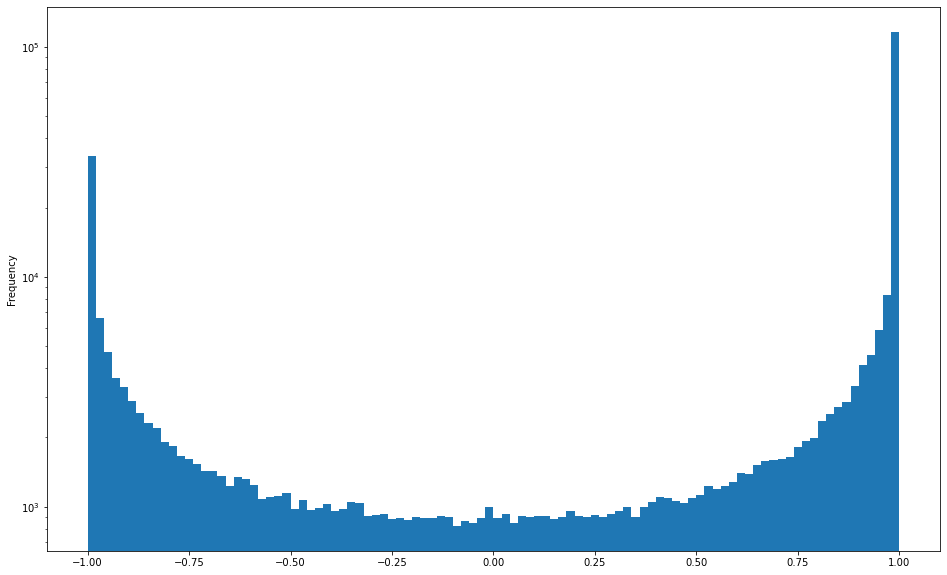

In [11]:
cut["imb"].plot.hist(bins=100, log=True)